In [128]:
import numpy as np
import pandas as pd
import geopandas as gpd

In [129]:
df = gpd.read_file('geolayers/Ленинградская область.geojson')
migr = gpd.read_file('geolayers/Миграция Ленинградская область.geojson')
pred = pd.read_csv('predictions.csv')

In [112]:
# migr['Численность населения (чел.)'].hist()

<Axes: >

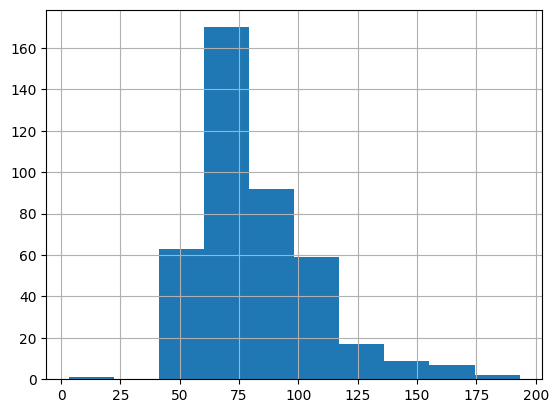

In [130]:
dis = pred.groupby('name_o')['d'].mean()
dis.hist()

<Axes: >

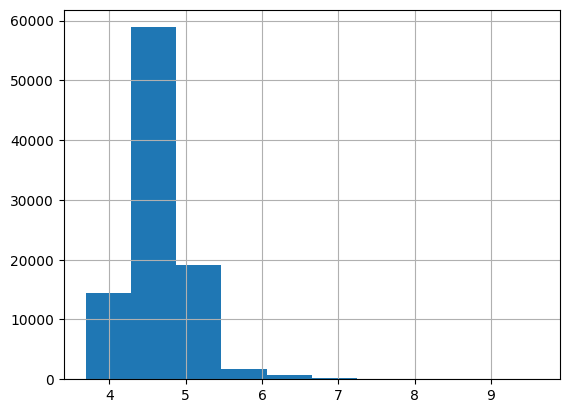

In [131]:
np.log(pred.sort_values('total_pop_flow')['total_pop_flow']).hist()

In [132]:
df.geometry.explore()

In [133]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point


# Формируем список всех городов
cities = pd.DataFrame({"city": pd.concat([pred["name_o"], pred["name_d"]]).unique()})

# Добавляем координаты
coords_o = pred.groupby("name_o")[["lat_o", "lon_o"]].first().reset_index()
coords_d = pred.groupby("name_d")[["lat_d", "lon_d"]].first().reset_index()

cities = cities.merge(coords_o, left_on="city", right_on="name_o", how="left").drop(columns=["name_o"])
cities = cities.merge(coords_d, left_on="city", right_on="name_d", how="left").drop(columns=["name_d"])

# Объединяем координаты
cities["lat"] = cities["lat_o"].fillna(cities["lat_d"])
cities["lon"] = cities["lon_o"].fillna(cities["lon_d"])
cities = cities.drop(columns=["lat_o", "lon_o", "lat_d", "lon_d"])

# Считаем уехавших и приехавших
departures = pred.groupby("name_o")["total_pop_flow"].sum().reset_index().rename(columns={"name_o": "city", "total_pop_flow": "уехало"})
arrivals = pred.groupby("name_d")["total_pop_flow"].sum().reset_index().rename(columns={"name_d": "city", "total_pop_flow": "приехало"})

# Объединяем данные
cities = cities.merge(departures, on="city", how="left").merge(arrivals, on="city", how="left").fillna(0)

# Создаем геометрию точек
cities["geometry"] = cities.apply(lambda row: Point(row["lon"], row["lat"]), axis=1)

# Преобразуем в GeoDataFrame
gdf = gpd.GeoDataFrame(cities, geometry="geometry", crs="EPSG:4326")

In [134]:
# Присоединяем города к полигонам (пространственный join)
gdf = gdf.sjoin(df, how="left", predicate="within")

# Группируем по полигону и считаем сумму уехало/приехало
polygon_stats = gdf.groupby("index_right")[["уехало", "приехало"]].sum().reset_index()

# Объединяем обратно с полигонами
result = df.merge(polygon_stats, left_index=True, right_on="index_right", how="left").fillna(0)


In [135]:
result.sort_values('уехало', ascending=False)

Малые города  Крупные города  Численность населения  \
3              1               0                 554288   
4              0               0                 195374   
5             14               0                 261898   
10             0               0                  85329   
1              0               0                  50211   
13             0               0                  57047   
11             1               0                  75307   
17             4               0                 133109   
6              4               0                  83838   
8              0               0                 108460   
2              0               0                  50211   
14             0               0                  45192   
0              2               0                  50977   
16             0               0                  66266   
9              3               0                  27548   
12             2               0                  25508   
7              0               0                  59877   
15             0               0                  64121   

   Административный центр Субъект Российской Федерации  \
3              Всеволожск        Ленинградская область   
4                  Выборг        Ленинградская область   
5                 Гатчина        Ленинградская область   
10              Ломоносов        Ленинградская область   
1                Волосово        Ленинградская область   
13              Приозерск        Ленинградская область   
11                   Луга        Ленинградская область   
17                  Тосно        Ленинградская область   
6               Кингисепп        Ленинградская область   
8                 Кировск        Ленинградская область   
2                  Волхов        Ленинградская область   
14                 Сланцы        Ленинградская область   
0            Бокситогорск        Ленинградская область   
16                 Тихвин        Ленинградская область   
9           Лодейное Поле        Ленинградская область   
12             Подпорожье        Ленинградская область   
7                  Кириши        Ленинградская область   
15           Сосновый Бор        Ленинградская область   

    Населенные пункты, количество  \
3                             152   
4                             180   
5                             240   
10                            144   
1                             201   
13                            100   
11                            348   
17                            115   
6                             190   
8                             100   
2                             281   
14                            156   
0                             259   
16                            197   
9                             121   
12                             69   
7                              77   
15                              1   

    Моногорода, наукограды, исторические поселения    centreX    centreY  \
3                                                0  30.785600  60.285139   
4                                                0  28.848132  60.541977   
5                                                0  30.173449  59.378176   
10                                               2  29.422521  59.817948   
1                                                0  29.350708  59.351487   
13                                               1  30.278897  60.803818   
11                                               1  29.816039  58.854390   
17                                               0  31.019282  59.372864   
6                                                2  27.959742  59.771915   
8                                                1  31.460892  60.003204   
2                                                3  32.420101  60.244491   
14                                               1  28.361827  59.083461   
0                                                1  34.615967  59.540529   
16         

In [136]:
result['dif'] = (result['приехало'] - result['уехало']) /1000

In [137]:
result.explore(column='dif')

In [138]:
migr['dif'] = migr['Количество приехавших'] - migr['Количество уехавших']
migr[['Количество уехавших','Количество приехавших', 'dif', 'geometry']][migr['name'].isna()][1:].explore(column='dif')